### ライブラリ・データの読み込み
これからの作業に必要なライブラリと問題のデータを読み込みます。

In [1]:
import pandas as pd #データ分析用
import numpy as np  #データ分析用

train = pd.read_csv('train.csv') #訓練データ
test = pd.read_csv("test.csv") #テストデータ
gender = pd.read_csv("gender_submission.csv") #同梱されていた提出用ファイルのサンプル

### データの確認
まずはどのようなデータが入っているか見てみましょう。

In [2]:
train.head() #訓練データの要素を見る：head()で最初の５行を見ることができる

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
gender.head() #どうやって提出するか見る

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# 文字列の変換・欠損値の処理

訓練データは、このままだと学習を行うことができません。  
学習時には各特徴量を数値データとして読み込ませる必要があるので、文字として書かれているものを数字に変える必要があります。  
また、欠損値があるとエラーが出る可能性があります。

特徴量の前処理のために、訓練データとテストデータを結合させたDataframeを作成します。  
これは、欠損値の補完や文字列データの数値変換を一度に行うためです。

In [4]:
data = pd.concat([train, test], sort=False) #concatで複数のdfを結合させる(sortオプションでソートしないようにしている)

### 欠損値の確認
どのデータにどのくらい欠損値が含まれているか確認しましょう。

In [5]:
data.isnull() #nullが入っているかどうかをチェックする

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
413,False,True,False,False,False,True,False,False,False,False,True,False
414,False,True,False,False,False,False,False,False,False,False,False,False
415,False,True,False,False,False,False,False,False,False,False,True,False
416,False,True,False,False,False,True,False,False,False,False,True,False


これだとよく分かりませんね。別のメソッドと組み合わせてみましょう。

In [6]:
data.isnull().sum() #sumと組み合わせることで欠損値が入っているかすぐ確認ができる

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

欠損値がいくつかの属性にあることが分かりました。欠損値の扱いにはいくつかの選択肢があります。
- __欠損のあるデータ行ごと削除する__
    - data.dropna()でnullのある行を削除できる
    - 簡単だがデータ量が減る
    - 欠損の分布によっては訓練データが偏ったものになる
- __欠損値に何らかの値を補完する__
    - 補完の仕方が結果に関わる
    -　平均値や最頻値など方法は様々
    - nullだった、という値を設定して埋める方法もある
    
発展：また、欠損値にもタイプがあります。
- ランダムに欠損している
    - 例：記録されていない・文字が読めない
- 特定の属性だと欠損する
    - 例：健康診断で、年齢によって測定をしていない項目が欠損している
- 特定の値だと欠損する
    - 例：測定可能な範囲外だった場合
    
タイプによって補完方法も変わります。今回は触れません。

###  文字列の変換・欠損の補完  
データの加工が必要な属性について作業を行います。

__性別__：この属性は、文字列で表されています。数値に変換しましょう。  
また、「inplace=True」とすることで、置換対象のDataframe(今回はdata)がそのまま変更されます。  
このオプションが無い場合は、置換がされている新しいDataaframeが返されます。

In [7]:
data['Sex'].replace(['male','female'], [0, 1], inplace=True) #maleを0に、femaleを1に変換する。

__出発地__：欠損が2つありました。補完するために内訳を見てみましょう。

In [8]:
data['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

「S」が大多数を占めていました。欠損の2件も「S」で補完し、性別と同じように数値に変換しましょう。  

また、今回の変換ではpandas.Seriesのmapメソッドを使っています。このメソッドは関数を引数として各要素・行に適用します。  
引数に辞書型を指定すると、その辞書に従った置換を行います。replace()で置換を行うよりも速いようです。  
注意：mapによる置換は全ての要素を置換する場合に有効です。（置換前の要素が辞書になかった場合NaNに置換されるので工夫が必要、今回は触れない）

In [9]:
data['Embarked'].fillna(('S'), inplace=True) #欠損値を置換するメソッド
data['Embarked'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int) #mapを使った置換

__運賃__：欠損が１つありました。平均値で補完します。

In [10]:
data['Fare'].fillna(np.mean(data['Fare']), inplace=True)

__年齢__：欠損が263個もあります。精度はともかく最頻値で埋めといてみましょう。

In [11]:
data['Age'].fillna(data['Age'].median(), inplace=True)

残りの属性は一旦無視します。

In [12]:
delete_columns = ['Name', 'PassengerId', 'SibSp', 'Parch', 'Ticket', 'Cabin']
data.drop(delete_columns, axis=1, inplace=True) #リストで行を指定することでまとめて削除できる

置換作業が終わったので訓練データとテストデータに戻しておきましょう。

In [13]:
train = data[:len(train)] #スライスを使って、先頭から訓練データの数だけを切り取る
test = data[len(train):] #訓練データの数から数えてその後を切り取る

学習用に、訓練データを特徴量と正解に分けます。  
慣例として、特徴量データは大文字でX、正解は小文字でyとしています。

In [14]:
y_train = train['Survived'] #訓練データの答えの部分を作る
X_train = train.drop('Survived', axis=1) #訓練データの特徴量だけの部分を作る
X_test = test.drop('Survived', axis=1) #dataに結合した時に付いたSurvivedを削除しておく

データの整形がとりあえず完了しました。それぞれのDataFrameを確認してみましょう。

In [15]:
X_train.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,0,22.0,7.2500,0
1,1,1,38.0,71.2833,1
2,3,1,26.0,7.9250,0
3,1,1,35.0,53.1000,0
4,3,0,35.0,8.0500,0


In [16]:
y_train.head()

0    0.0
1    1.0
2    1.0
3    1.0
4    0.0
Name: Survived, dtype: float64

In [17]:
X_test.head()

,Pclass,Sex,Age,Fare,Embarked
0,3,0,34.5,7.8292,2
1,3,1,47.0,7.0000,0
2,2,0,62.0,9.6875,2
3,3,0,27.0,8.6625,0
4,3,1,22.0,12.2875,0


# 機械学習

やっと学習に入ります。機械学習には様々なアルゴリズムがあります。色々試してみましょう。

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

アルゴリズムを選び、clfという変数に予測器を宣言します。  
３つの中からコメントアウトを外して選んでみましょう。

In [19]:
#clf = RandomForestClassifier(random_state=0)
#clf = LogisticRegression(penalty='l2', solver="sag", random_state=0)
#clf = SVC(kernel = "rbf")

選んだアルゴリズムで学習を行います。

In [20]:
clf.fit(X_train, y_train) #訓練データに基づいた学習

/Users/saito/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

これで変数clfに学習済の学習器ができました。テストデータの予想をさせてみましょう。

In [21]:
y_pred =  clf.predict(X_test) #y_predに予想が入る

In [22]:
y_pred[:5] #予想が入っているか確認

array([0., 0., 0., 1., 1.])

これで機械学習が一通りできました。  
実際にKaggleに提出できるようにしましょう。

In [23]:
sub = gender #サンプルファイルを参考に作る
sub['Survived'] = list(map(int, y_pred)) #学習器の予想に書き換える
sub.to_csv("submission.csv", index=False)  #csv形式に変換

サンプルファイルが無い場合は自力で作りましょう。問題のレギュレーションに従った形式のファイルを作成します。

In [24]:
sub = pd.read_csv("test.csv") 
sub = sub.loc[:,["PassengerId"]] #特定の列をdfとして取り出す
sub["Survived"]= list(map(int, y_pred)) #予測を列として追加する

In [25]:
sub.to_csv("submission.csv", index=False)

<br />
お疲れ様です。これでKaggleに提出ができます。  
ここからは精度・順位を上げるために工夫をしていきます。  

# 特徴量選択・追加

ここで、それぞれの属性が特徴量として使えそうか考えてみましょう。  

In [35]:
train_reform = pd.read_csv("train.csv") 
test_reform = pd.read_csv("test.csv")
train_reform.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


名前：名前で生き残れるかどうかが変わるとは考えにくいですね。使用は見送りましょう。  
チケット番号：等級と関係がありそうですが、その属性を参照すれば良いだけですね。使い道はあるかもしれませんが今は見送ります。  
部屋番号：部屋割りなどで生存率が変わりそうですが、欠損値が全体の７割近いです。調べることができれば利用できそうです。  
兄弟と配偶者(SibSp)：親族がいると災害時の行動が変わってきそうですね。特徴量として入れるべきかもしれません。  
親と子供の人数(Parch)：SibSpと同じく使えそうです。

ここで、家族の人数が生存率に関係がありそうだと考えました。データから検証してみましょう。

### グラフを描く
Seabornと呼ばれるライブラリを使ってグラフを描画してみましょう。
このライブラリは、グラフを描画するmatplotlibというライブラリの  
ラッパーライブラリ（元のライブラリに代わって違う環境で動いたり追加機能があるもの）です。

インポートの際には、元となるmatplotlibもインポートしましょう。  
また、jupyter notebook上でグラフを表示させる場合はインポート以外にも操作が必要です（しないと新しいウィンドウが開く）。  
「％」から始まる表記はマジックコマンドと呼ばれ、jupyter notebookで特殊な操作ができます。

In [31]:
import matplotlib.pyplot as plt #グラフの描画
import seaborn as sns #グラフの描画
%matplotlib inline  
#jupyter notebook上でグラフを表示させる

それではグラフを描いてみましょう。最初に「親と子供の人数別で何人が生存or死亡したか」のデータを見ます。  
数をカウントする場合はcountplotで、横軸をxに、カウントを分ける条件をhueに指定します。

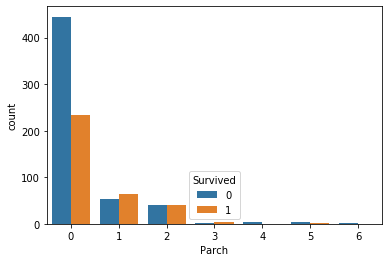

In [32]:
sns.countplot(x="Parch",data=train_reform,hue="Survived")

演習：「兄弟と配偶者の人数別で何人が生存or死亡したか」のグラフを描いてみましょう。

２つのグラフを見ると、１人でも家族が乗船しているかどうかが生存率と関係ありそうなことが分かります。  
新しい特徴量として使えるかもしれません。家族の人数を表す属性を作成してデータを確認します。

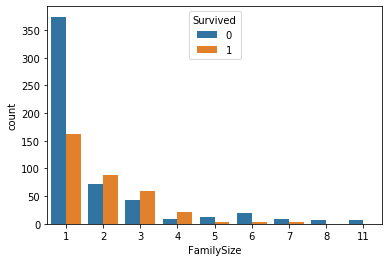

In [37]:
train_reform['FamilySize'] = train_reform['Parch'] + train_reform['SibSp'] + 1 #本人として１を足す
sns.countplot(x='FamilySize', data = train_reform, hue='Survived')

１人での乗船だと生存率が低いことが分かりました。  
演習：他にもデータから分かる特徴があるでしょうか？  
演習：新しく作った特徴量が精度に貢献しているか、Kaggleに提出してスコアを見てみましょう。
- テストデータにFamilySizeを足す
- 使わない特徴量を消す
- 特徴量データとラベルデータに分ける
- 学習させる
- 予想させる
- 予想結果をcsvファイルに変換して提出する